# Modeling COVID-19 Pandemic in New York State with Epydemix

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on weekly deaths during the first wave in New York State, US. 

Let's import needed packages:

In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_selected_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import calibrate
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
import numpy as np 
from scipy import stats 

Second, we import and plot the epidemic data on weekly deaths that we want to model:

<Axes: title={'center': 'New York State'}, xlabel='date', ylabel='weekly deaths'>

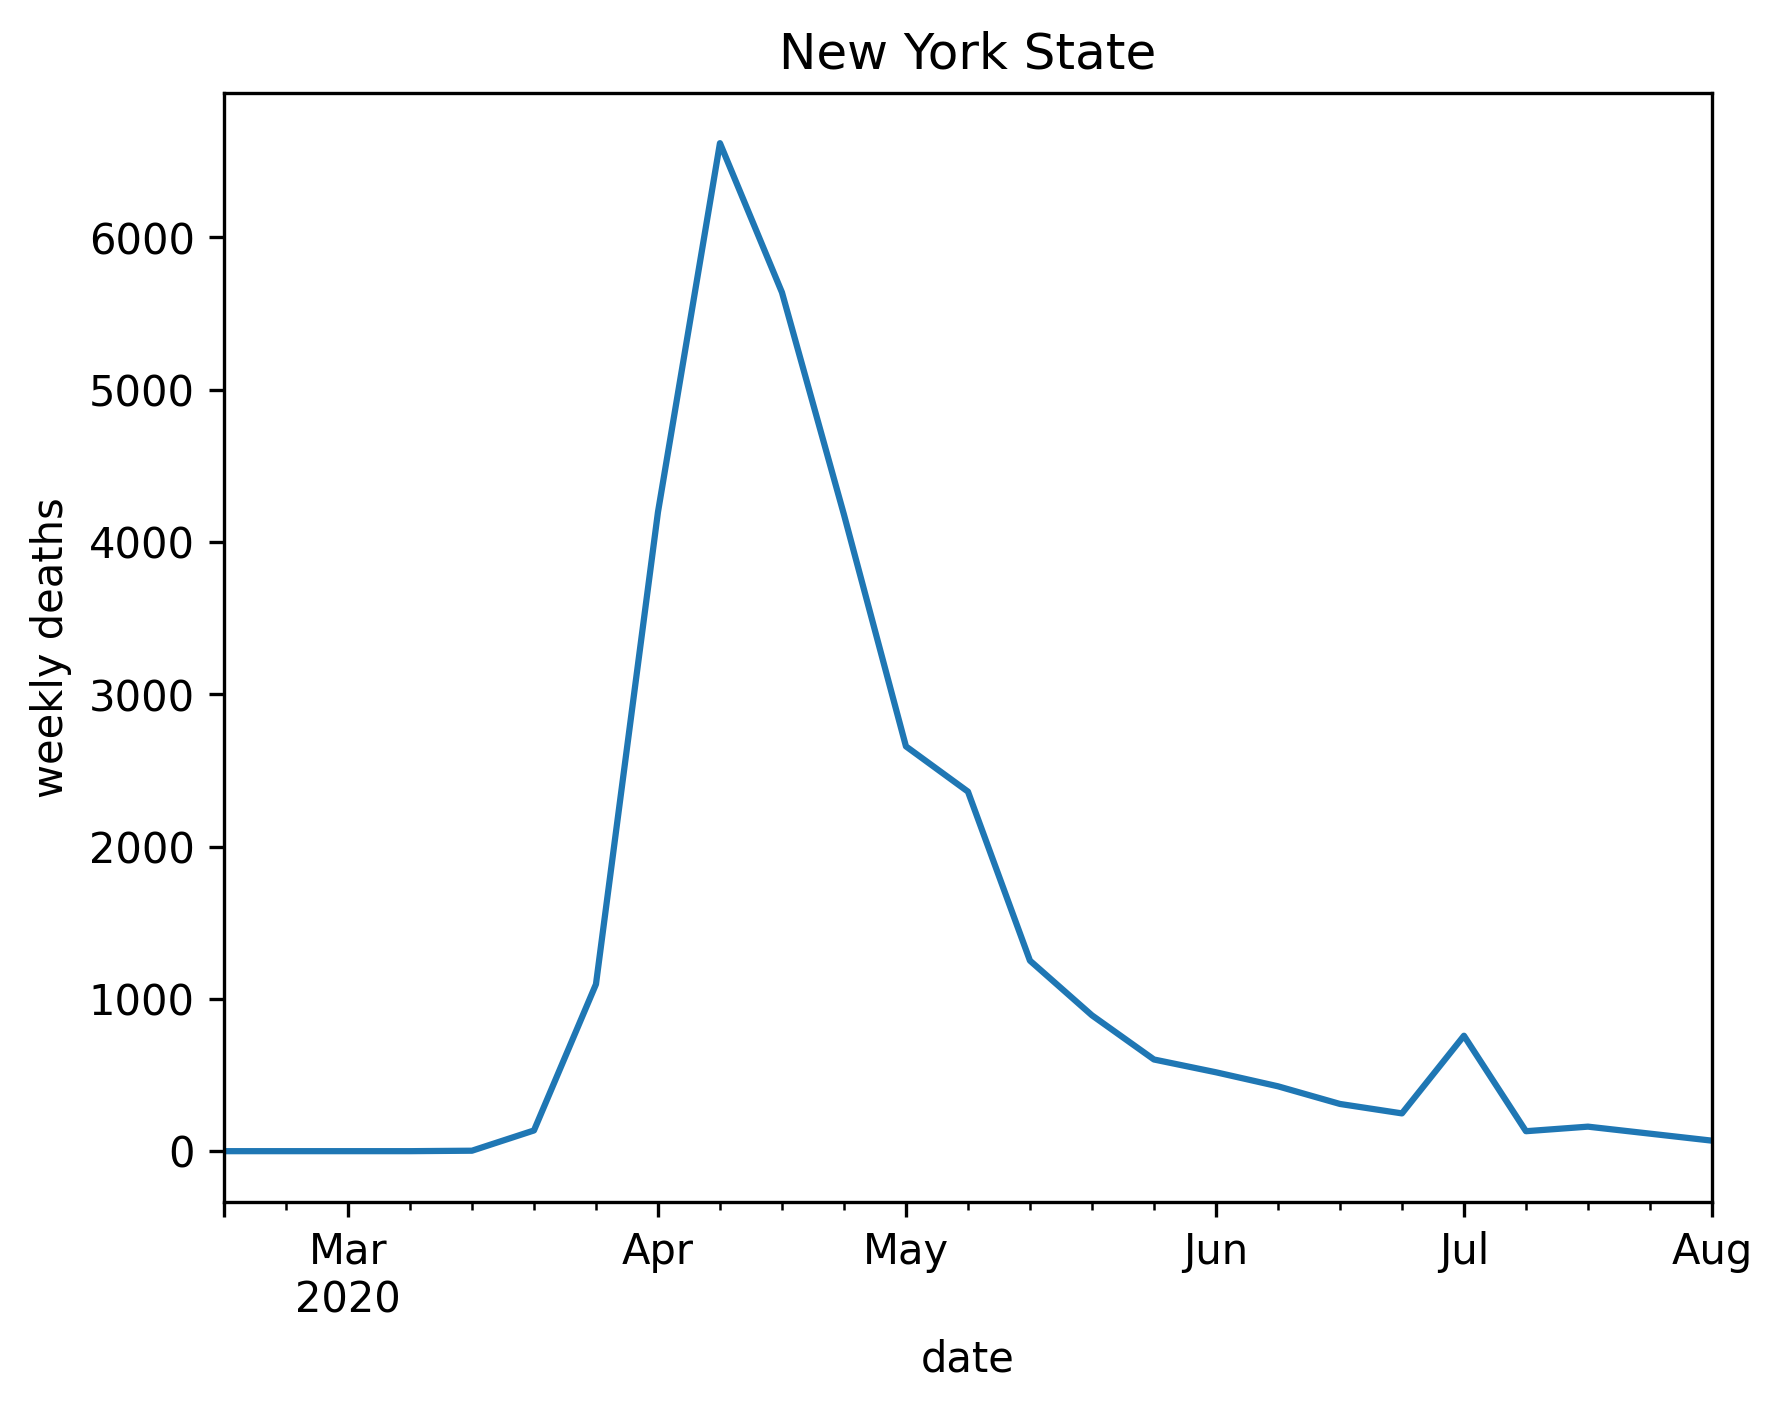

In [34]:
# import epidemic data 
epi_data = pd.read_csv("./data/ny_state/NY_deaths.csv")
epi_data.index = pd.to_datetime(epi_data.date)

fig, ax = plt.subplots(dpi=300)
epi_data.data.plot(ax=ax, title="New York State", ylabel="weekly deaths")

Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVID-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see REFS:

<Axes: title={'center': 'Contact reductions in New York State - COVID-19 First wave'}, xlabel='date', ylabel='$r(t)$'>

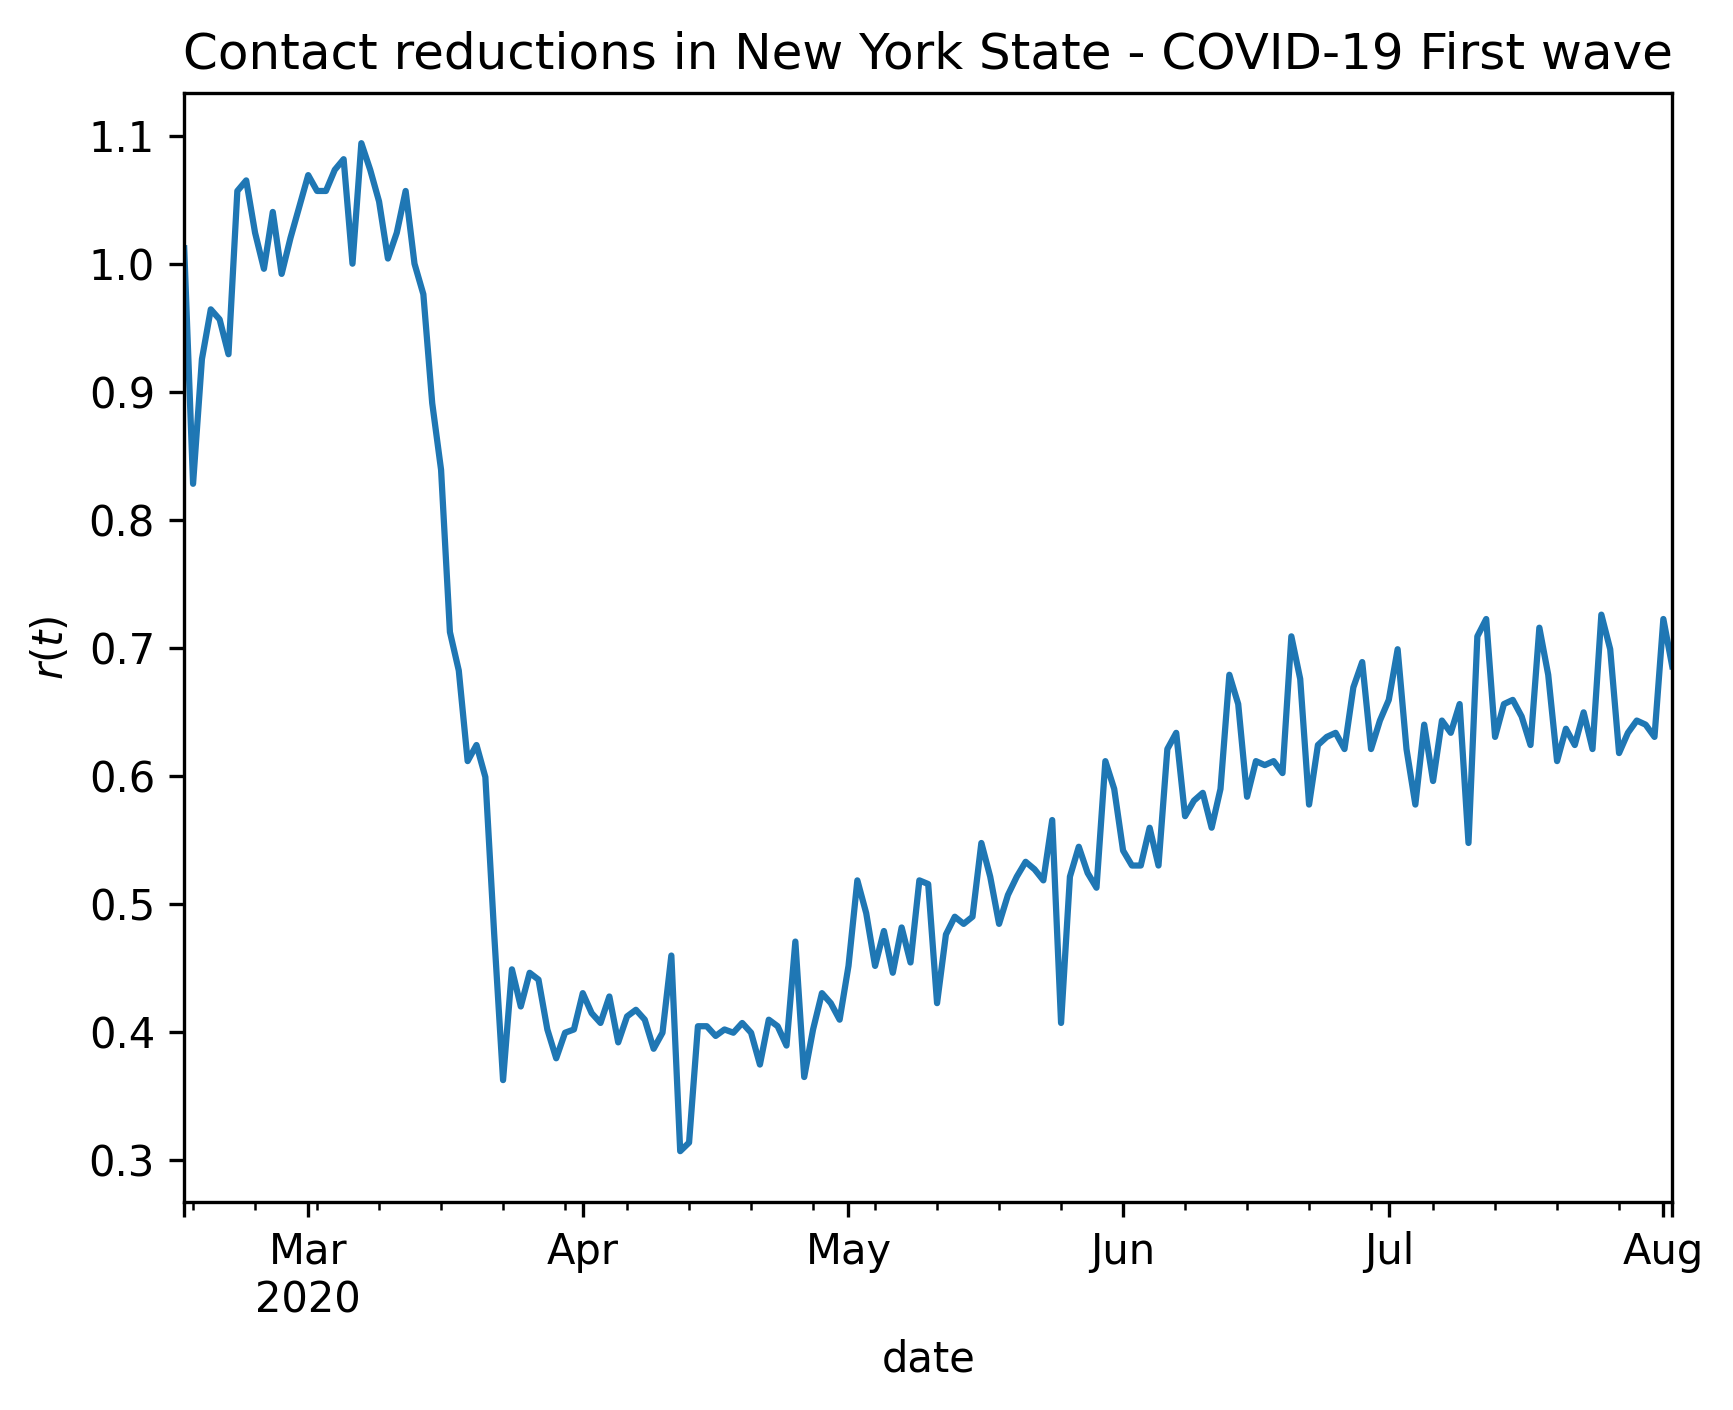

In [35]:
def compute_contact_reductions(mob_data, columns):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/ny_state/NY_google.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions.index = pd.to_datetime(contact_reductions.date)

fig, ax = plt.subplots(dpi=300)
contact_reductions.r.plot(ax=ax, title="Contact reductions in New York State - COVID-19 First wave", ylabel="$r(t)$")

We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

MODEL SCHEMA

The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [37]:
# create model 
model = EpiModel(compartments=["S", "E", "I", "R", "D0", "D1", "D2"])

# set population
population_nys = load_epydemix_population("United_States_New_York")
model.set_population(population_nys)

model.add_parameter(parameters_dict={"mu": 1. / 2.5, 
                                     "eps": 1. / 4., 
                                     "r": contact_reductions["r"].values, 
                                     "IFR": convert_to_2Darray([0.0000161, 0.0000695, 0.000768,
                                                                0.012625,0.0467])})

model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu*(1-IFR)")
model.add_transition(source="I", target="D0", rate="mu*IFR")
model.add_transition(source="D0", target="D1", rate="1./Delta*2")
model.add_transition(source="D1", target="D2", rate="1./Delta*2")
print(model)

EpiModel(name='EpiModel')
Compartments: 7
  S, E, I, R, D0, D1, D2
Transitions: 6
  Transitions between compartments:
    S -> E, rate: beta*r
    E -> I, rate: eps
    I -> R, rate: mu*(1-IFR)
    I -> D0, rate: mu*IFR
    D0 -> D1, rate: 1./Delta*2
    D1 -> D2, rate: 1./Delta*2
Parameters: 4
  Model parameters:
    mu: 0.4
    eps: 0.25
    r: [1.012036 0.8281   0.925444 0.964324 0.956484 0.929296 1.056784 1.065024
 1.024144 0.996004 1.0404   0.992016 1.0201   1.044484 1.069156 1.056784
 1.056784 1.073296 1.0816   1.       1.094116 1.073296 1.048576 1.004004
 1.024144 1.056784 1.       0.976144 0.891136 0.839056 0.712336 0.682276
 0.611524 0.6241   0.599076 0.4761   0.362404 0.4489   0.419904 0.446224
 0.440896 0.401956 0.379456 0.399424 0.401956 0.430336 0.414736 0.407044
 0.427716 0.391876 0.412164 0.417316 0.4096   0.386884 0.399424 0.459684
 0.306916 0.3136   0.404496 0.404496 0.3969   0.401956 0.399424 0.407044
 0.399424 0.374544 0.4096   0.404496 0.389376 0.470596 0.364816 0.4

We are almost ready for the calibration:

In [18]:
def custom_initial_conditions(epimodel, I0): 
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {"S": epimodel.population.Nk - infected_by_age, 
            "E": (infected_by_age / 2).astype(int),
            "I": (infected_by_age / 2).astype(int)}


def simulate_wrapper(parameters): 
    # custom initial conditions
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})
    # simulate
    results = simulate(**parameters)
    # compute weekly deaths
    daily_deaths = pd.DataFrame(data={"new_deaths": np.concatenate(([0], np.diff(results["D2_total"])))}, index=parameters["simulation_dates"])
    weekly_deaths = daily_deaths.resample("W").sum()
    results.update({"data": weekly_deaths.new_deaths.values})
    return results

priors = {"beta": stats.uniform(0.04, 0.1 - 0.04), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(10, 10000)}

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1])
parameters = {"epimodel": model, 
              "simulation_dates": simulation_dates}

results = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": epi_data["data"].values},  
                    num_particles=500, 
                    max_generations=5)

Running generation 1, epsilon: 2420.42612310946
	Elapsed time: 00:03:03
Running generation 2, epsilon: 1981.4933000519454
	Elapsed time: 00:03:15
Running generation 3, epsilon: 1649.160853192314
	Elapsed time: 00:03:33
Running generation 4, epsilon: 1419.3596071618495
	Elapsed time: 00:03:23
Running generation 5, epsilon: 1229.5193155856282
	Elapsed time: 00:04:29


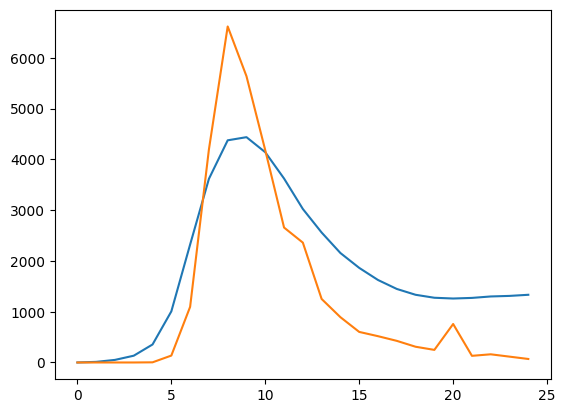

In [32]:
plt.plot(np.median(results.get_selected_trajectories()["data"], axis=0))
plt.plot(epi_data["data"].values)

In [30]:
from epydemix.utils import compute_quantiles
df_quantiles_abc_smc = compute_quantiles(results.get_selected_trajectories(), 
                                         simulation_dates=pd.DataFrame(index=simulation_dates).resample("W").sum().index, 
                                         resample_frequency="W")

plot_selected_quantiles(df_quantiles_abc_smc, epi_data, title="ABC-SMC")   


ValueError: Shape of passed values is (169, 500), indices imply (25, 500)

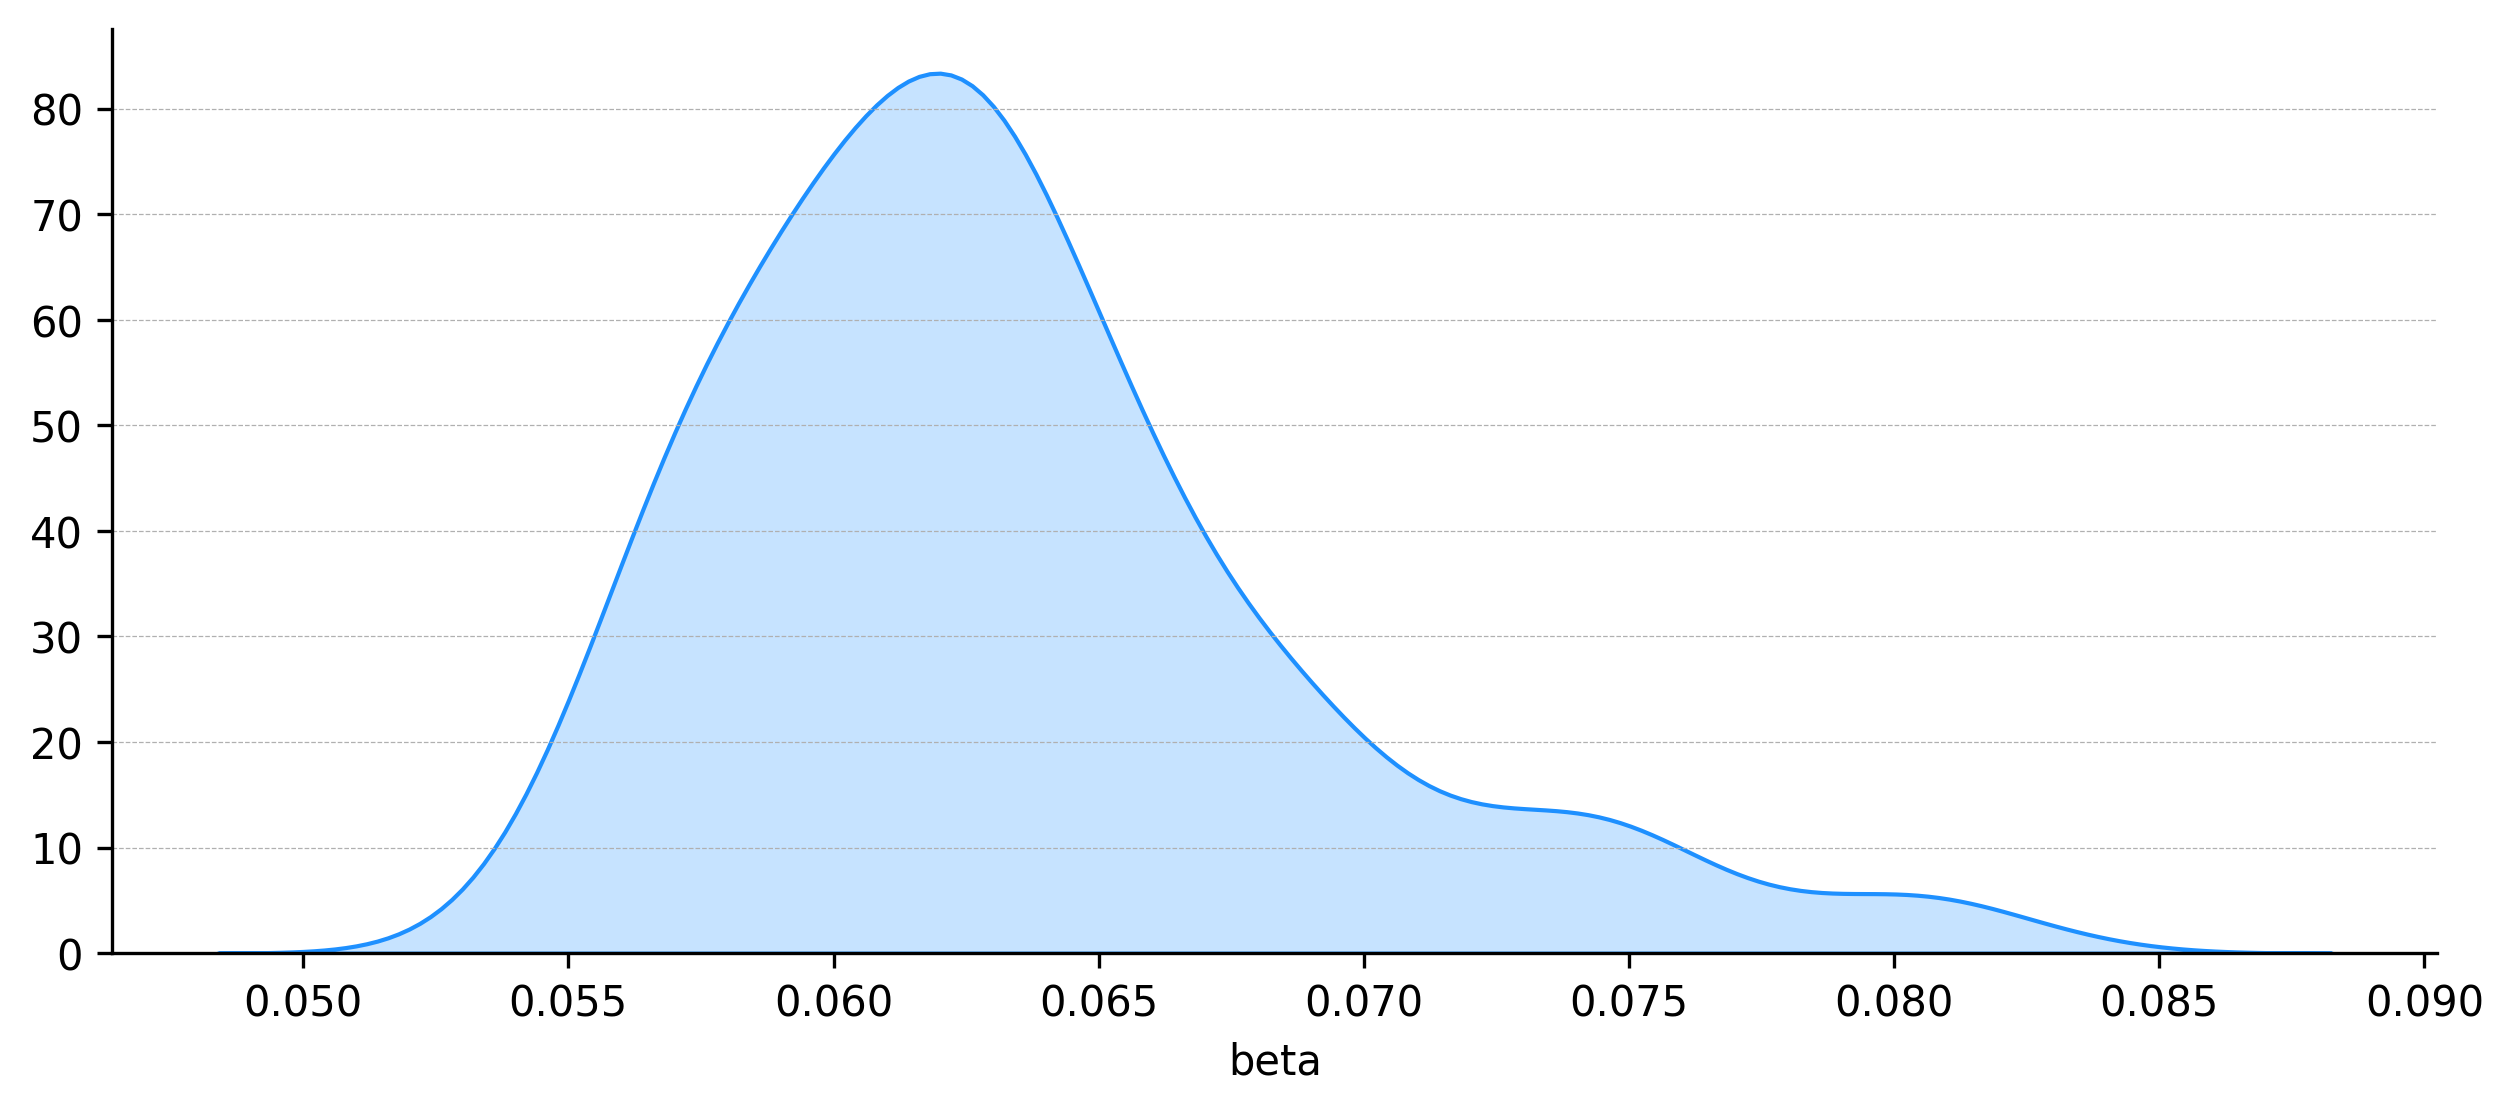

In [11]:
plot_posterior(results, "beta", kind="kde")

/Users/nicolo/Desktop/epydemix/epydemix/visualization/plotting.py:260: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


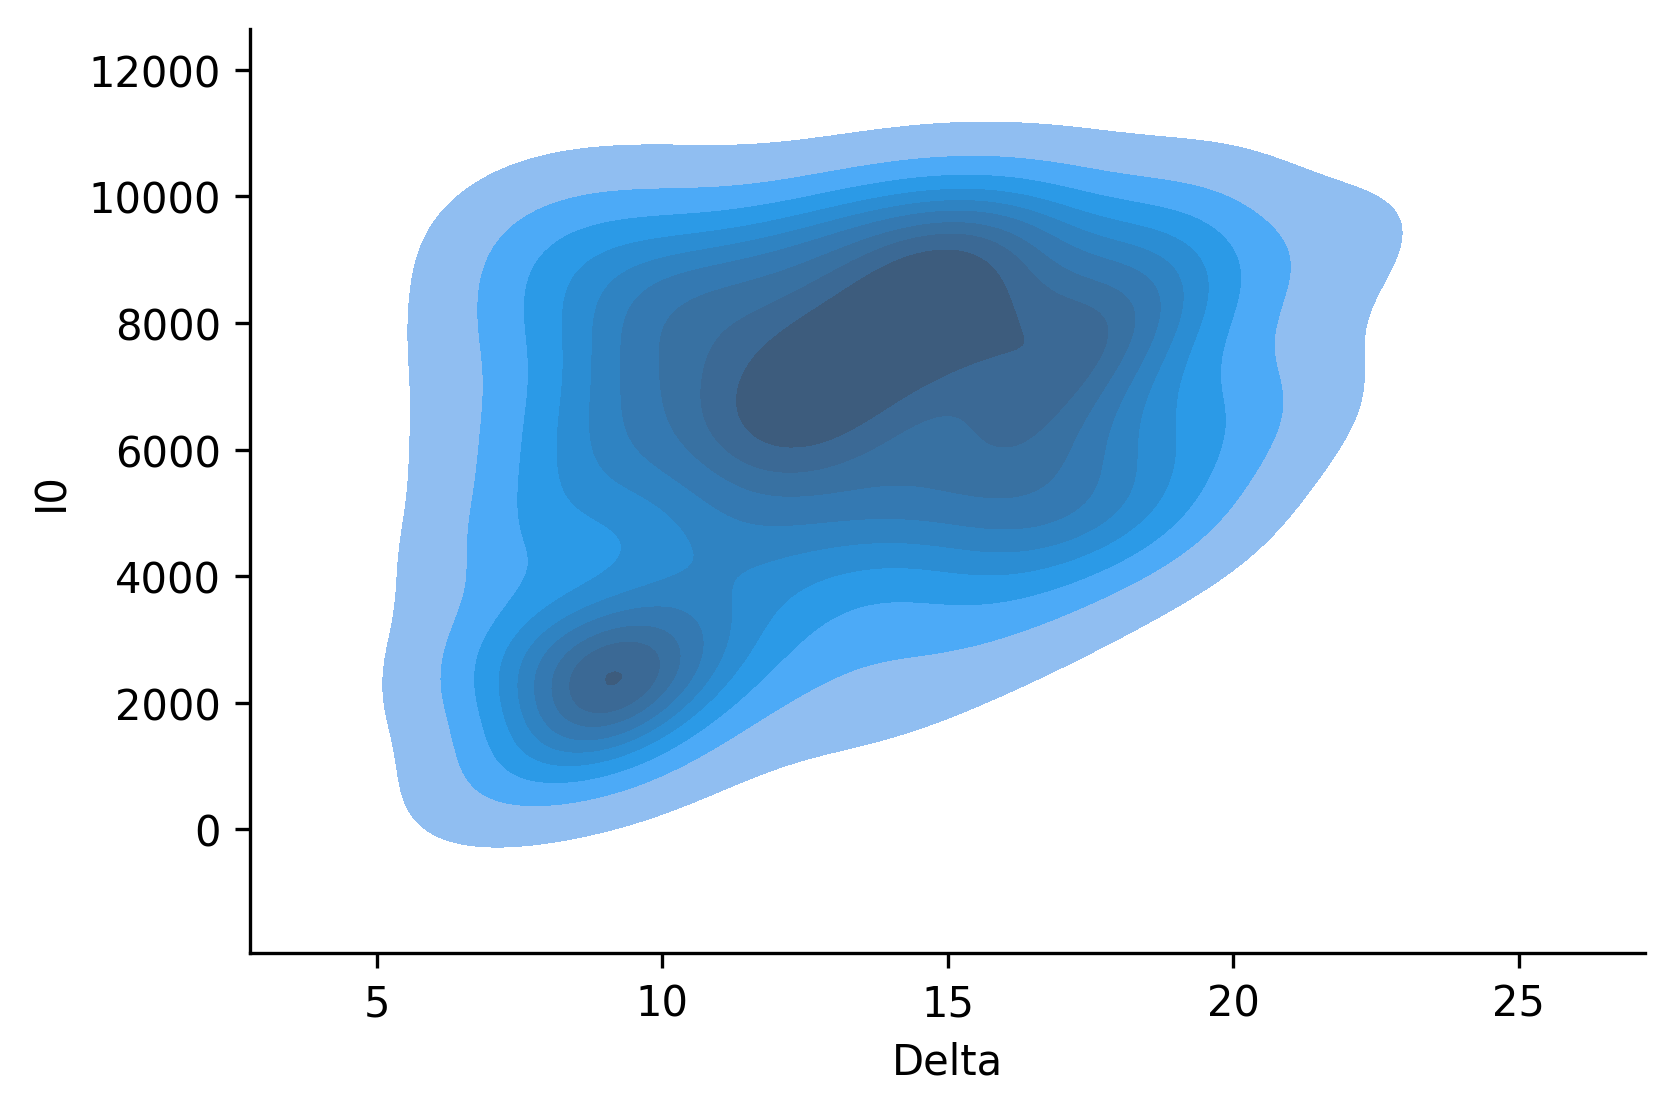

In [15]:
plot_posterior_2d(results, "Delta", "I0", kind="kde")